# Data Assimilation for One-dimensional GW flow model
Data assimilation combine model predictions and observations. In this notebook, the model will be setup first and then it will be used to generate a set  of synthatic observations.

In [1]:
import time
start_time = time.time()
import os, sys
import numpy as np
import pandas as pd
import configparser
import pyemu
import matplotlib.pyplot as plt
import inspect
import shutil
import flopy

## Config Parameters
In this exercise, we will use multiple user configuration parameters. To make things clean, we used the a configuration file to hold all these parameters.


In [2]:
config = configparser.ConfigParser()
config.read("config.init")
fidw = open("config.init", 'r')
settings = fidw.read()
fidw.close()
print(settings)

[workspace]
basename = flow1d
template_folder = flow1d_tmp
worker_folder =  flow1d_worker

[model_info]
input_files = input_dis.csv, hk_1.dat, iheads_1.dat
output_files = output_sim.csv

[da_settings]
vs_code_dir = r"D:\Workspace\projects\mississippi\pure_c_pestpp\pestpp"
num_realizations = 50
ensemble_filename = heads_out.csv

[da_ensemble]
seed_number = 42
correlation_length = 50
number_of_realizations = 50






## Setup workspace
Create a template folder that will contain model executable, model input files, and model output files. It is 
called "template" because the worker will be generated from it.

In [3]:
template_ws = os.path.join(".", config.get('workspace', 'template_folder')) # od_flow os one dim flow model
if not(os.path.isdir(template_ws)):
    os.mkdir(template_ws)
else:
    shutil.rmtree(template_ws)
print(os.path.abspath(template_ws))

D:\Workspace\projects\mississippi\manuscripts\pestppda_paper\notebooks\one_dim_flow_enkf\flow1d_tmp


## Model description
A Python function "generate_1d_model" is used to setup a 1D GW flow model as well as misc files that we will be used and showed in this notebook. The following are the main features in the model:- 
* The model consists of one layer, one row, and 100 columns. 
* The model generates a one-row model where a general head boundary (GHB = -10 m) exist at the upstream and another on GHB downstream (GHB = -20). We should interpret the negative number as depth below groundsurface level.
* The model consists of 24 stress periods, and each stress period has 30 time steps.
* Recharge is applied uniformly in space and variably in time at all cells. 
* In the middle cell a groundwater pumping is applied. 

Let us generate the model and look more at it's component. For detailed in formation about model setup, please see "generate_1d_model" in file model_setup. Look at output at the end of the simulation.

FloPy is using the following  executable to run the model: D:\Workspace\projects\mississippi\manuscripts\pestppda_paper\notebooks\bin\win\mfnwt.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.0.9 07/01/2014                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.03.0 08/30/2013                       

 Using NAME file: flow_1d.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/06/05 14:10:42

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress

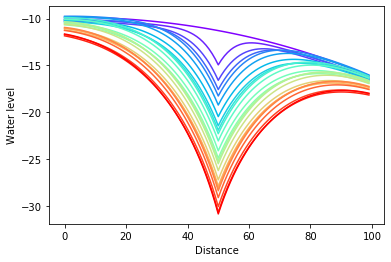

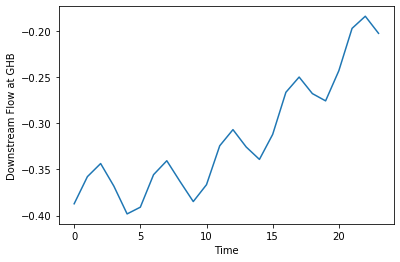

In [4]:
#2) create a simple flow model
from model_setup import generate_1d_model
figs = generate_1d_model() # this is a simple script that setup the 1D flow problem. 


The GW pumping causes a depression cone to develop and grow with time.

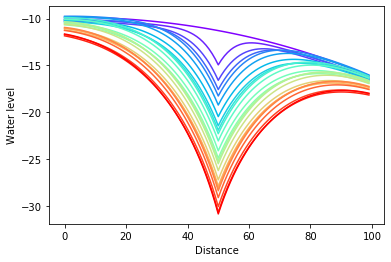

In [5]:
%matplotlib inline
figs[0]

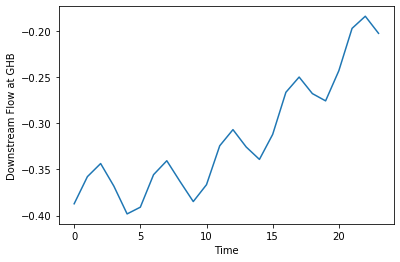

In [6]:
figs[1]

In [7]:
# Copy the generated model to the template folder
print(os.listdir())
shutil.copytree('model_dataset', os.path.join(template_ws, 'model_dataset'))
shutil.rmtree('model_dataset')
shutil.copy('..\param_utils.py', os.path.join(template_ws, 'param_utils.py'))
shutil.copy('..\obs_utils.py', os.path.join(template_ws, 'obs_utils.py'))

['.ipynb_checkpoints', 'config.init', 'flow1d_worker', 'misc_files', 'model_dataset', 'model_setup.py', 'one_dim_flow.ipynb', 'PstFrom.log', 'xxxx_tobe_remove_forward_model.py', '__pycache__']


'.\\flow1d_tmp\\obs_utils.py'

### Simplifying Model I/O
We write a Python warapper that takes one file for each parameter group and generate one output file as output. Let us look at the model input files. and output file is similar to observation data section. This is just a personal preference! you may still deals with the native MODFLOW I/O files.
* input_dis.csv
* hk_1.dat
* iheads_1.dat

The model script (model_setup.py) has a function called "forward_model" that will work as our model.

In [8]:
import model_setup
src_forward_run = inspect.getsource(model_setup.forward_run)
print(src_forward_run)

def forward_run():
    modelname = "flow_1d"
    model_ws = r"model_dataset"

    # always start by removing old output files
    try:
        os.remove(os.path.join(model_ws, "output_sim.csv"))
    except:
        pass

    input_dis = pd.read_csv(os.path.join(model_ws, "input_dis.csv"))
    temporal_df = pd.read_csv(os.path.join(model_ws, "temporal_param.csv"))

    mf = flopy.modflow.Modflow.load(f=modelname + ".nam", model_ws=model_ws)

    # ------ update dis
    start_sp = input_dis.loc[input_dis['parname'] ==  'start_sp', 'parval'].values[0]
    end_sp = input_dis.loc[input_dis['parname'] ==  'end_sp', 'parval'].values[0]
    nlay = mf.dis.nlay
    nrow = mf.dis.nrow
    ncol = mf.dis.ncol
    delr = mf.dis.delr.array
    delc = mf.dis.delc.array
    ztop = mf.dis.top.array
    botm = mf.dis.botm.array

    time_mask = (temporal_df['stress_period'] >= start_sp) & \
                (temporal_df['stress_period'] <= end_sp)
    curr_tempora_df = temporal_df[time_mask]
    curr_sps 

In [9]:
# let us assemble the script that works as forward_model
script = """
import os, sys
import shutil
import numpy as np
import pandas as pd
import flopy
import matplotlib.pyplot as plt
import pyemu
import obs_utils, param_utils

{}
if __name__ == "__main__":
     forward_run()
 
""".format(src_forward_run)
print(script)


import os, sys
import shutil
import numpy as np
import pandas as pd
import flopy
import matplotlib.pyplot as plt
import pyemu
import obs_utils, param_utils

def forward_run():
    modelname = "flow_1d"
    model_ws = r"model_dataset"

    # always start by removing old output files
    try:
        os.remove(os.path.join(model_ws, "output_sim.csv"))
    except:
        pass

    input_dis = pd.read_csv(os.path.join(model_ws, "input_dis.csv"))
    temporal_df = pd.read_csv(os.path.join(model_ws, "temporal_param.csv"))

    mf = flopy.modflow.Modflow.load(f=modelname + ".nam", model_ws=model_ws)

    # ------ update dis
    start_sp = input_dis.loc[input_dis['parname'] ==  'start_sp', 'parval'].values[0]
    end_sp = input_dis.loc[input_dis['parname'] ==  'end_sp', 'parval'].values[0]
    nlay = mf.dis.nlay
    nrow = mf.dis.nrow
    ncol = mf.dis.ncol
    delr = mf.dis.delr.array
    delc = mf.dis.delc.array
    ztop = mf.dis.top.array
    botm = mf.dis.botm.array

    time_mask = (tem

In [10]:
# Let us write the model
with open(os.path.join(template_ws, r"forward_model.py"), 'w') as fidw:
    fidw.write(script)

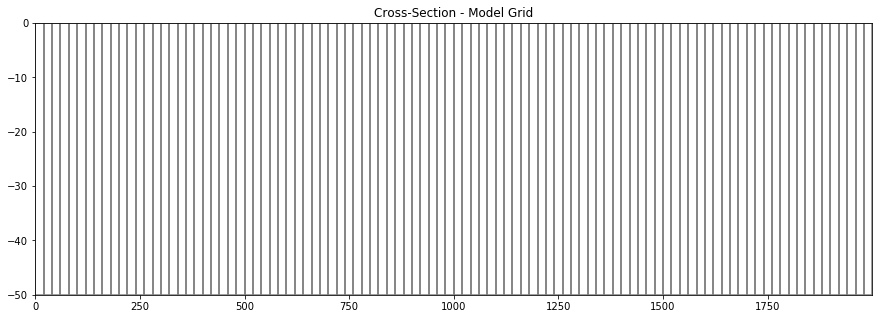

In [11]:
fnam = os.path.join(template_ws, r'model_dataset\flow_1d.nam')
mf = flopy.modflow.Modflow.load(os.path.basename(fnam), model_ws= os.path.dirname(fnam))
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
xsect = flopy.plot.PlotCrossSection(model=mf, line={'Row': 0})
linecollection = xsect.plot_grid()
t = ax.set_title('Cross-Section - Model Grid')

In [12]:
np.random.seed(int(config.get('da_ensemble', 'seed_number' )))
               
corr_scale = float(config.get('da_ensemble', 'correlation_length' ))
nx, ny = mf.nrow, mf.ncol # of cells
N = int(config.get('da_ensemble', 'number_of_realizations' )) # number of realizations
#m = int(config.get('da_ensemble', 'number_of_realizations' ) # number of measurements
refence_realization = 4
delc = mf.dis.delc.array
delr = mf.dis.delr.array

# pyemu allow us to define the spatial structure of grid. This object (sr) will be used later.
sr = pyemu.helpers.SpatialReference(delr=delr, delc=delc )


In [13]:
# Before running the model. Let us see something else. The trasnient data table.
trans_data = pd.read_csv(os.path.join(template_ws, r".\model_dataset\temporal_param.csv" ))
trans_data

,stress_period,perlen,nstp,GHB_UP,GHB_DN,Qw,Rch
0,0,30.0,30,-10.0,-20.0,0.0,0.000200
1,1,30.0,30,-10.0,-20.0,-3.5,-0.001717
2,2,30.0,30,-10.0,-20.0,-3.5,-0.000891
3,3,30.0,30,-10.0,-20.0,-3.5,0.001496
4,4,30.0,30,-10.0,-20.0,-3.5,0.002029
5,5,30.0,30,-10.0,-20.0,-3.5,-0.000056
6,6,30.0,30,-10.0,-20.0,-3.5,-0.001774
7,7,30.0,30,-10.0,-20.0,-3.5,-0.000668
8,8,30.0,30,-10.0,-20.0,-3.5,0.001681
9,9,30.0,30,-10.0,-20.0,-3.5,0.001910


In [14]:
base_folder = os.getcwd()
os.chdir(template_ws)
cmd = sys.executable
cmd = cmd + " " + "forward_model.py"
os.system(cmd)
os.chdir(base_folder)

In [15]:
out_df = pd.read_csv(os.path.join(template_ws, r".\model_dataset\output_sim.csv" ))
out_df

,obsnme,simval,obsval,weight,obgnme,comments
0,hf_0_0_0,-11.650773,0.0,1.0,simH,#
1,hf_0_0_1,-11.712117,0.0,1.0,simH,#
2,hf_0_0_2,-11.780944,0.0,1.0,simH,#
3,hf_0_0_3,-11.857170,0.0,1.0,simH,#
4,hf_0_0_4,-11.940759,0.0,1.0,simH,#
...,...,...,...,...,...,...
311,qghb_600,-0.275922,0.0,1.0,ghbQ,#
312,qghb_630,-0.243325,0.0,1.0,ghbQ,#
313,qghb_660,-0.197502,0.0,1.0,ghbQ,#
314,qghb_690,-0.184379,0.0,1.0,ghbQ,#


In [16]:
# We can change the start time and end time and run the model.
df_input = pd.read_csv(os.path.join(template_ws, r"model_dataset\input_dis.csv" ))
df_input.loc[df_input['parname']=='start_sp', 'parval'] = 5
df_input.loc[df_input['parname']=='end_sp', 'parval'] = 10
df_input.to_csv(os.path.join(template_ws, r"model_dataset\input_dis.csv" ))
base_folder = os.getcwd()
os.chdir(template_ws)
cmd = sys.executable
cmd = cmd + " " + "forward_model.py"
os.system(cmd)
os.chdir(base_folder)

# PstFrom to setup the problem.

In [17]:
# Generate a pf object
new_d =  os.path.join(".", config.get('workspace', 'worker_folder'))
pf = pyemu.utils.PstFrom(original_d=template_ws, new_d=new_d,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False,start_datetime="1-1-2021", multi_threads = False)

2021-06-05 14:11:03.448277 starting: opening PstFrom.log for logging
2021-06-05 14:11:03.449329 starting PstFrom process
2021-06-05 14:11:03.450277 starting: setting up dirs
2021-06-05 14:11:03.451279 starting: removing existing new_d 'flow1d_worker'
2021-06-05 14:11:03.483238 finished: removing existing new_d 'flow1d_worker' took: 0:00:00.031959
2021-06-05 14:11:03.483238 starting: copying original_d 'flow1d_tmp' to new_d 'flow1d_worker'
2021-06-05 14:11:03.578098 finished: copying original_d 'flow1d_tmp' to new_d 'flow1d_worker' took: 0:00:00.094860
2021-06-05 14:11:03.581080 finished: setting up dirs took: 0:00:00.130803


In [18]:
par_fn = os.path.join(template_ws,r"model_dataset\input_dis.csv")
pf.add_parameters(filenames=par_fn, use_cols=["parval"], par_type='grid', index_cols=['parname'],
                  par_name_base="sfr_", pargp="sfr_cn", ult_ubound=50, ult_lbound=1e-3,
                  par_style='direct', transform='log') 

2021-06-05 14:11:03.593500 starting: adding grid type direct style parameters for file(s) ['model_dataset\\input_dis.csv']
2021-06-05 14:11:03.594627 starting: loading list flow1d_worker\model_dataset\input_dis.csv
2021-06-05 14:11:03.594627 starting: reading list flow1d_worker\model_dataset\input_dis.csv
2021-06-05 14:11:03.601542 finished: reading list flow1d_worker\model_dataset\input_dis.csv took: 0:00:00.006915
2021-06-05 14:11:03.601576 loaded list 'flow1d_worker\model_dataset\input_dis.csv' of shape (2, 3)
2021-06-05 14:11:03.606541 finished: loading list flow1d_worker\model_dataset\input_dis.csv took: 0:00:00.011914
2021-06-05 14:11:03.607540 starting: writing list-based template file 'flow1d_worker\input_dis.csv.tpl'
2021-06-05 14:11:03.651315 finished: writing list-based template file 'flow1d_worker\input_dis.csv.tpl' took: 0:00:00.043775
2021-06-05 14:11:03.681044 finished: adding grid type direct style parameters for file(s) ['model_dataset\\input_dis.csv'] took: 0:00:00.08

In [19]:
# add input file that contains parameters
par_fn =  os.path.join(template_ws,r"model_dataset\hk_1.dat")
par_name_base = 'k'
pargp = 'KH'

v = pyemu.utils.geostats.ExpVario(a=corr_scale,contribution=1.0)
grid_gs = pyemu.utils.geostats.GeoStruct(variograms=v,nugget=0.0)

pf.add_parameters(filenames=par_fn, par_type="grid",
                  par_name_base=par_name_base, pargp=pargp,
                  upper_bound=3., lower_bound=-3, ult_ubound=3.0, ult_lbound=-3,
                  geostruct=grid_gs, transform='none', par_style='direct')

2021-06-05 14:11:03.696257 starting: adding grid type direct style parameters for file(s) ['model_dataset\\hk_1.dat']
2021-06-05 14:11:03.697340 starting: loading array flow1d_worker\model_dataset\hk_1.dat
2021-06-05 14:11:03.701259 finished: loading array flow1d_worker\model_dataset\hk_1.dat took: 0:00:00.003919
2021-06-05 14:11:03.702258 loaded array 'flow1d_tmp\model_dataset\hk_1.dat' of shape (1, 100)
2021-06-05 14:11:03.705257 starting: writing array-based template file 'flow1d_worker\hk_1.dat.tpl'
2021-06-05 14:11:03.706257 starting: writing template file flow1d_worker\hk_1.dat.tpl for ['k_inst:0']
2021-06-05 14:11:03.711262 WARNING: get_xy() warning: position of i and j in index_cols not specified, assume (i,j) are final two entries in index_cols.
2021-06-05 14:11:03.736653 finished: writing template file flow1d_worker\hk_1.dat.tpl for ['k_inst:0'] took: 0:00:00.030396
2021-06-05 14:11:03.737258 finished: writing array-based template file 'flow1d_worker\hk_1.dat.tpl' took: 0:00:

In [20]:
# add input file that contains parameters
par_fn =  os.path.join(template_ws,r"model_dataset\iheads_1.dat")
par_name_base = 'h'
pargp = 'Hs'

v = pyemu.utils.geostats.ExpVario(a=corr_scale,contribution=1.0)
grid_gs = pyemu.utils.geostats.GeoStruct(variograms=v,nugget=0.0)

pf.add_parameters(filenames=par_fn, par_type="grid",
                  par_name_base=par_name_base, pargp=pargp,
                  upper_bound=0, lower_bound=-50, ult_ubound= 0, ult_lbound=-50,
                  geostruct=grid_gs, transform='none', par_style='direct')

2021-06-05 14:11:03.780151 starting: adding grid type direct style parameters for file(s) ['model_dataset\\iheads_1.dat']
2021-06-05 14:11:03.781151 starting: loading array flow1d_worker\model_dataset\iheads_1.dat
2021-06-05 14:11:03.784150 finished: loading array flow1d_worker\model_dataset\iheads_1.dat took: 0:00:00.002999
2021-06-05 14:11:03.785210 loaded array 'flow1d_tmp\model_dataset\iheads_1.dat' of shape (1, 100)
2021-06-05 14:11:03.789150 starting: writing array-based template file 'flow1d_worker\iheads_1.dat.tpl'
2021-06-05 14:11:03.790150 starting: writing template file flow1d_worker\iheads_1.dat.tpl for ['h_inst:0']
2021-06-05 14:11:03.793412 WARNING: get_xy() warning: position of i and j in index_cols not specified, assume (i,j) are final two entries in index_cols.
2021-06-05 14:11:03.821546 finished: writing template file flow1d_worker\iheads_1.dat.tpl for ['h_inst:0'] took: 0:00:00.031396
2021-06-05 14:11:03.821546 finished: writing array-based template file 'flow1d_work

In [24]:
output_file =os.path.join(template_ws,r"model_dataset\output_sim.csv")
output_file = r"D:\Workspace\projects\mississippi\manuscripts\pestppda_paper\notebooks\one_dim_flow_enkf\flow1d_worker\model_dataset\output_sim.csv"
df_out = pd.read_csv(output_file)
ins_file =output_file + ".ins"
obs_prefix = 'h' ## Note: using capital letter will cause issues
obsgp = 'heads'
hds_df = pf.add_observations(output_file,insfile=ins_file,index_cols="obsnme",
                    use_cols= ['simval'],prefix=obs_prefix, obsgp = obsgp, ofile_sep = ",")


2021-06-05 14:10:12.163437 finished: adding observations from tabular output file took: 0:04:20.336457


ValueError: I/O operation on closed file.

In [ ]:
pf.mod_sys_cmds.append(cmd)
pst = pf.build_pst(version=2)

pe = pf.draw(num_reals=N, sigma_range= 10, use_specsim=True)
pe.to_csv(os.path.join(new_d, 'HKensemble.csv'))
## Select one realization to represent the unknown truth (the actual reference field). From this truth realization choose observations.
x_true = pe._df.iloc[refence_realization].values

In [ ]:
plt.figure()
plt.plot(pe._df.T.values)
plt.show()

ens =  pe._df.values.T
y_ref = ens[:, refence_realization]
y_index = df_index['idx'].astype(int).values # measurement index

print(y_ref[y_index])
print(y_index)

plt.figure()
plt.plot(ens, color = [0.7,0.7,0.7], zorder=1)
plt.plot(ens[:,refence_realization])
plt.scatter(y_index, y_ref[y_index], color = 'r', zorder = 2)
plt.show()

In [ ]:
# this a synthatic problem, so we need observations. The observation is generated from the reference realization
inputx = y_ref + np.zeros_like(delr)
inputx = inputx[np.newaxis, :]
np.savetxt(os.path.join(template_ws, 'inputx.dat'), inputx)

In [ ]:
# run the model using the synthatic realization
base_folder = os.getcwd()
os.chdir(template_ws)
cmd = sys.executable
cmd = cmd + " " + "forward_model.py"
os.system(cmd)
os.chdir(base_folder)

In [ ]:
# read output
df_obs = pd.read_csv(os.path.join(template_ws,'heads_out.csv'))
df_obs

In [ ]:
## use observation from the reference
pst.observation_data['obsval'] = df_obs['y'].values
pst.observation_data['weight'] = 1000 # this is 1/std
pst.observation_data['cycle'] = 0 # ensemble smoother
#pst.observation_data['state_par_link']

pst.parameter_data['cycle'] = 0
pst.parameter_data['parchglim'] = 'relative'
pst.model_input_data['cycle'] = 0
pst.model_output_data['cycle'] = 0

pst.svd_data.eigthresh =  1e-5
pst.pestpp_options['da_add_base']= False
pst.pestpp_options['da_parameter_ensemble']= 'HKensemble.csv'
#pst.pestpp_options['DA_SUBSET_SIZE'] = 50
pst.pestpp_options['da_num_reals'] = N
pst.pestpp_options['ies_init_lam'] = [1]
pst.pestpp_options['ies_lambda_mults'] = 1
pst.pestpp_options['lambda_scale_fac'] = 1
pst.control_data.noptmax = 1

In [ ]:
pst.model_command[0] = pst.model_command[0].replace('python', sys.executable)
pst.write(os.path.abspath(pf.pst.filename), version=2)

## Important check locations of ins and templpe

In [ ]:
shutil.copy2(os.path.join(vs_code_dir,"exe","windows","x64","Debug","pestpp-da.exe"),os.path.join(new_d,"pestpp-da.exe"))

In [ ]:
import subprocess
base_folder = os.getcwd()
os.chdir(new_d)
argv = ["pestpp-da.exe", os.path.basename(pf.pst.filename)]
def run_command(cmd):
    with subprocess.Popen(cmd, stdout=subprocess.PIPE, bufsize=1, universal_newlines=True) as p:
        while True:
            line = p.stdout.readline()
            if not line:
                break
            print(line)    
        exit_code = p.poll()
    return exit_code


run_command(argv)

os.chdir(base_folder)

In [ ]:
posterior_par = pd.read_csv(os.path.join(new_d, template_ws+".global.0.pe.csv"))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(ens, color = [0.7,0.7,0.7], zorder=1, label = 'Prior K')
handles, labels = ax.get_legend_handles_labels()
display = []
display.append(len(labels))

ax.plot(ens[:,refence_realization], 'g', zorder = 3)
handles, labels = ax.get_legend_handles_labels()
display.append(len(labels))

ax.scatter(y_index, y_ref[y_index], color = 'r', zorder = 3)
handles, labels = ax.get_legend_handles_labels()
display.append(display[-1] + len(labels))

del(posterior_par['real_name'])
ax.plot(posterior_par.values.T, color = 'b', label = 'Posterior K')
handles, labels = ax.get_legend_handles_labels()
display.append(display[-1] + len(labels))

ax.legend([handle for i,handle in enumerate(handles) if i in display],
      [label for i,label in enumerate(labels) if i in display], loc = 'best')


In [ ]:
## Try more iterations for 

In [ ]:
pst.pestpp_options['da_num_reals'] = N
pst.pestpp_options['DA_SUBSET_SIZE'] = 10
pst.pestpp_options['ies_init_lam'] = [10]
pst.pestpp_options['ies_lambda_mults'] = [0.1, 1, 10]
pst.pestpp_options['lambda_scale_fac'] = 1
pst.control_data.noptmax = 5 # number of iterations
pst.write(os.path.abspath(pf.pst.filename), version=2)

In [ ]:
import subprocess
base_folder = os.getcwd()
os.chdir(new_d)
argv = ["pestpp-da.exe", os.path.basename(pf.pst.filename)]
def run_command(cmd):
    with subprocess.Popen(cmd, stdout=subprocess.PIPE, bufsize=1, universal_newlines=True) as p:
        while True:
            line = p.stdout.readline()
            if not line:
                break
            print(line)    
        exit_code = p.poll()
    return exit_code


run_command(argv)

os.chdir(base_folder)

In [ ]:
posterior_par = pd.read_csv(os.path.join(new_d, template_ws+".global.0.pe.csv"))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(ens, color = [0.7,0.7,0.7], zorder=1, label = 'Prior K')
handles, labels = ax.get_legend_handles_labels()
display = []
display.append(len(labels))

ax.plot(ens[:,refence_realization], 'g', zorder = 3)
handles, labels = ax.get_legend_handles_labels()
display.append(len(labels))

ax.scatter(y_index, y_ref[y_index], color = 'r', zorder = 3)
handles, labels = ax.get_legend_handles_labels()
display.append(display[-1] + len(labels))

del(posterior_par['real_name'])
ax.plot(posterior_par.values.T, color = 'b', label = 'Posterior K')
handles, labels = ax.get_legend_handles_labels()
display.append(display[-1] + len(labels))

ax.legend([handle for i,handle in enumerate(handles) if i in display],
      [label for i,label in enumerate(labels) if i in display], loc = 'best')

In [ ]:
sys.path.append(r"..")
import rec_util 
import rec_util
ws = r"D:\Workspace\projects\mississippi\manuscripts\pestppda_paper\notebooks\one_dim_flow\new_od_flow_template"
fname = r"od_flow_template.rec"

fname = os.path.join(ws, fname)
rec = rec_util.RecFile(fname= os.path.join(new_d, template_ws+".rec"))

